(image-segmentation:voronoi-otsu-labeling=)
# Voronoi-Otsu标记
这种图像分割工作流是一种相当简单但功能强大的方法，例如用于检测和分割荧光显微镜图像中的细胞核。细胞核标记物如核GFP、DAPI或组蛋白RFP与各种显微技术结合使用可以生成适当类型的图像。

In [1]:
from skimage.io import imread, imshow
import matplotlib.pyplot as plt
import pyclesperanto_prototype as cle
import napari_segment_blobs_and_things_with_membranes as nsbatwm

为了演示这个工作流程，我们使用来自[Broad生物图像挑战](https://bbbc.broadinstitute.org/BBBC022)的图像数据：
我们使用了图像集BBBC022v1 [Gustafsdottir et al., PLOS ONE, 2013](http://dx.doi.org/10.1371/journal.pone.0080999)，该数据集可从Broad生物图像基准集合获得 [Ljosa et al., Nature Methods, 2012](http://dx.doi.org/10.1038/nmeth.2083)。

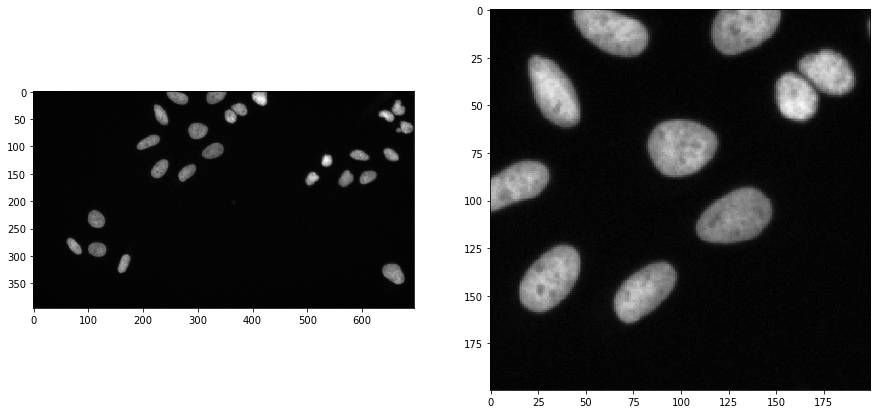

In [2]:
input_image = imread("../../data/BBBC022/IXMtest_A02_s9.tif")[:,:,0]

input_crop = input_image[0:200, 200:400]

fig, axs = plt.subplots(1, 2, figsize=(15, 15))
cle.imshow(input_image, plot=axs[0])
cle.imshow(input_crop, plot=axs[1])

## 应用算法
Voronoi-Otsu标记是clesperanto中的一个命令，需要两个sigma参数。第一个sigma控制检测到的细胞可以有多接近（`spot_sigma`），第二个控制分割对象的轮廓精确度（`outline_sigma`）。

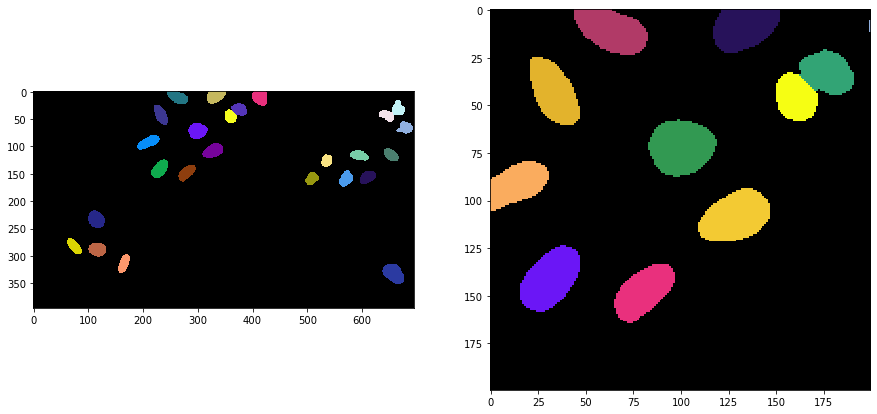

In [3]:
sigma_spot_detection = 5
sigma_outline = 1

segmented = cle.voronoi_otsu_labeling(input_image, spot_sigma=sigma_spot_detection, outline_sigma=sigma_outline)
segmented_crop = segmented[0:200, 200:400]

fig, axs = plt.subplots(1, 2, figsize=(15, 15))
cle.imshow(segmented, labels=True, plot=axs[0])
cle.imshow(segmented_crop, labels=True, plot=axs[1])

## 它是如何工作的？
Voronoi-Otsu标记工作流是高斯模糊、斑点检测、阈值处理和二值分水岭的组合。感兴趣的读者可以查看[开源代码](https://github.com/clEsperanto/pyclesperanto_prototype/blob/master/pyclesperanto_prototype/_tier9/_voronoi_otsu_labeling.py)。这种方法类似于对二值图像应用种子分水岭，例如在[MorphoLibJ](https://imagej.net/plugins/marker-controlled-watershed)或[scikit-image](https://scikit-image.org/docs/dev/api/skimage.segmentation.html#skimage.segmentation.watershed)中。然而，种子是自动计算的，不能传入。

为了演示目的，我们只在上面显示的2D裁剪图像上进行操作。如果将此算法应用于3D数据，建议首先使其等方。

In [4]:
image_to_segment = input_crop
print(image_to_segment.shape)

(200, 200)


作为第一步，我们用给定的sigma对图像进行模糊处理，并在结果图像中检测最大值。

number of detected spots 29.0


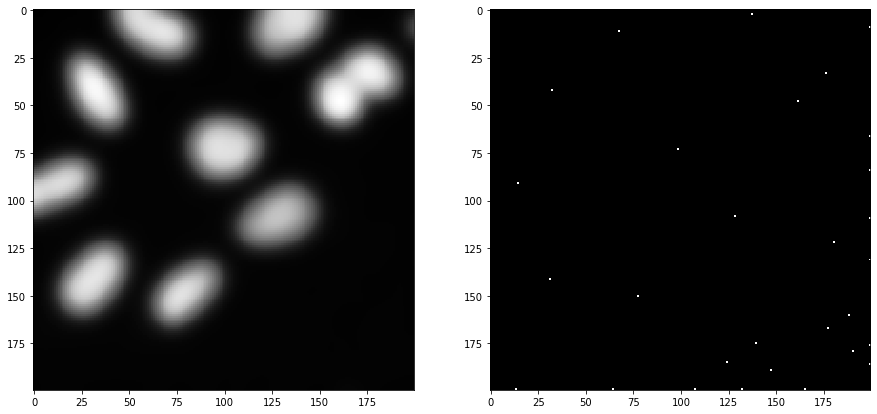

In [5]:
blurred = cle.gaussian_blur(image_to_segment, sigma_x=sigma_spot_detection, sigma_y=sigma_spot_detection, sigma_z=sigma_spot_detection)

detected_spots = cle.detect_maxima_box(blurred, radius_x=0, radius_y=0, radius_z=0)

number_of_spots = cle.sum_of_all_pixels(detected_spots)
print("检测到的斑点数量", number_of_spots)

fig, axs = plt.subplots(1, 2, figsize=(15, 15))
cle.imshow(blurred, plot=axs[0])
cle.imshow(detected_spots, plot=axs[1])

此外，我们再次从裁剪后的图像开始，用不同的sigma再次进行模糊处理。之后，我们使用[大津阈值法（Otsu et al 1979）](https://doi.org/10.1109%2FTSMC.1979.4310076)对图像进行阈值处理。

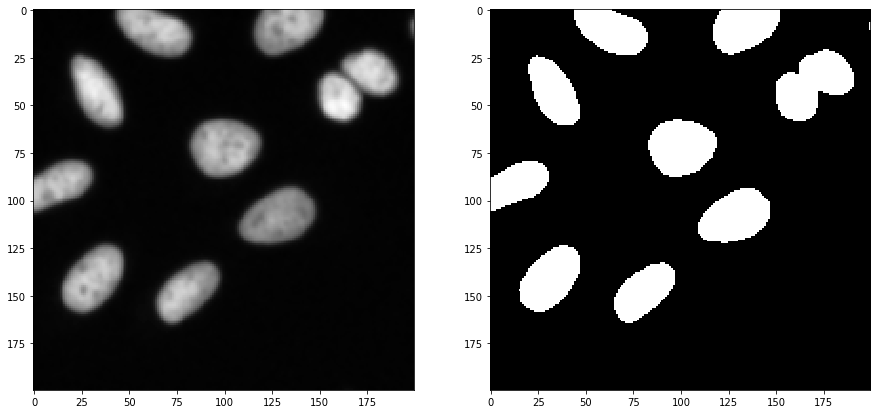

In [6]:
blurred = cle.gaussian_blur(image_to_segment, sigma_x=sigma_outline, sigma_y=sigma_outline, sigma_z=sigma_outline)

binary = cle.threshold_otsu(blurred)

fig, axs = plt.subplots(1, 2, figsize=(15, 15))
cle.imshow(blurred, plot=axs[0])
cle.imshow(binary, plot=axs[1])

之后，我们取二值斑点图像和二值分割图像，应用`binary_and`操作以排除在背景区域检测到的斑点。这些可能对应于噪声。

number of selected spots 11.0


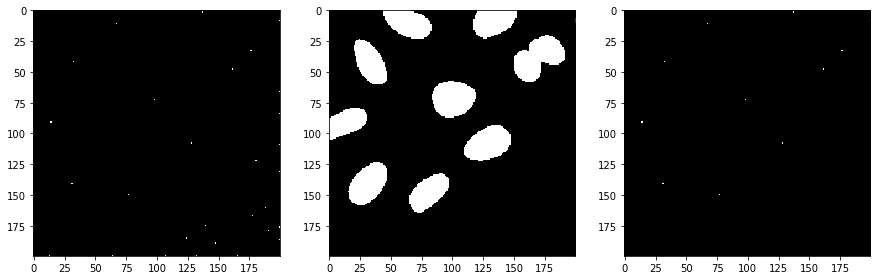

In [7]:
selected_spots = cle.binary_and(binary, detected_spots)

number_of_spots = cle.sum_of_all_pixels(selected_spots)
print("选中的斑点数量", number_of_spots)

fig, axs = plt.subplots(1, 3, figsize=(15, 15))
cle.imshow(detected_spots, plot=axs[0])
cle.imshow(binary, plot=axs[1])
cle.imshow(selected_spots, plot=axs[2])

接下来，我们使用[Voronoi图](https://en.wikipedia.org/wiki/Voronoi_diagram#References)在选定的斑点之间分割图像空间，该图限制在二值图像的正像素中。

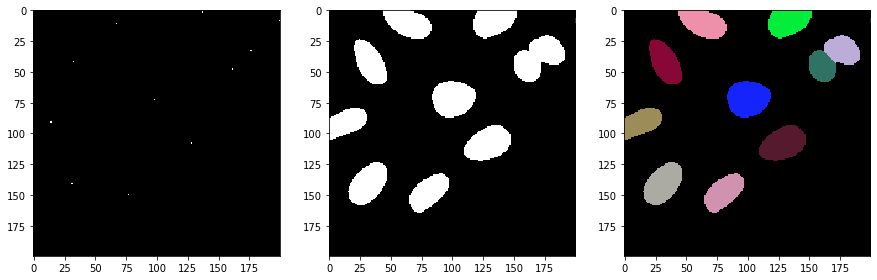

In [8]:
voronoi_diagram = cle.masked_voronoi_labeling(selected_spots, binary)

fig, axs = plt.subplots(1, 3, figsize=(15, 15))
cle.imshow(selected_spots, plot=axs[0])
cle.imshow(binary, plot=axs[1])
cle.imshow(voronoi_diagram, labels=True, plot=axs[2])

## 其他Voronoi-Otsu标记实现

在可脚本化的napari插件[napari-segment-blobs-and-things-with-membranes](https://github.com/haesleinhuepf/napari-segment-blobs-and-things-with-membranes)中有该算法的另一种实现。

这里的代码与上面的代码几乎相同。主要区别在于我们调用`nsbatwm.voronoi_otsu_labeling()`而不是`cle.voronoi_otsu_labeling()`。

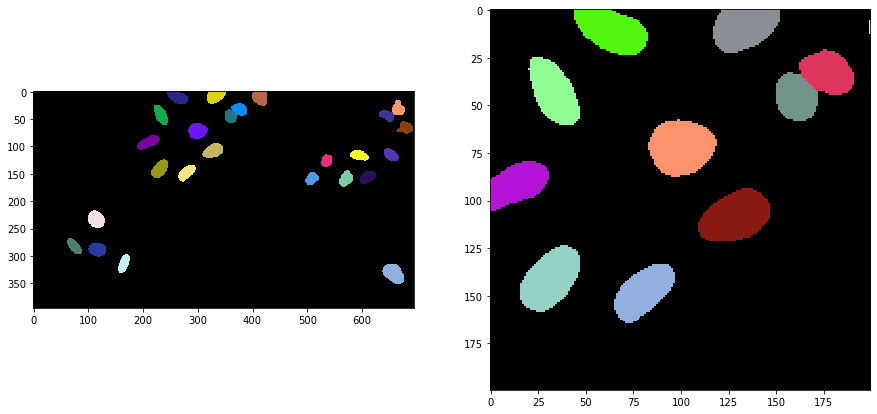

In [9]:
sigma_spot_detection = 5
sigma_outline = 1

segmented2 = nsbatwm.voronoi_otsu_labeling(input_image, spot_sigma=sigma_spot_detection, outline_sigma=sigma_outline)

segmented_crop2 = segmented2[0:200, 200:400]

fig, axs = plt.subplots(1, 2, figsize=(15, 15))
cle.imshow(segmented2, labels=True, plot=axs[0])
cle.imshow(segmented_crop2, labels=True, plot=axs[1])